## Milestone 2 

1) That you can handle the data in its size.

The datasets obtained from FAO are quite small in size as we can pre-filter the features that we are interested in before downloading them from the FAO website. 
    
2) That you understand what’s into the data (formats, distributions, missing values, correlations, etc.).

We have begun to clean our data and the formats are clear and understandable. The missing values for our war data have been filled manually. As for the FAO dataset, ... 

3) That you considered ways to enrich, filter, transform the data according to your needs.

4) That you have updated your plan in a reasonable way, reflecting your improved knowledge after data acquaintance. In particular, discuss how your data suits your project needs and discuss the methods you’re going to use, giving their essential mathematical details in the notebook.
    
5) That your plan for analysis and communication is now reasonable and sound, potentially discussing alternatives to your choices that you considered but dropped.


In [170]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("..")
plt.xkcd()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A general overview of impact of armed conflicts on agriculture

## Wars Dataframe creation

The data about wars have been downloaded from Wikidata, using the query in the [get_wiki_data.py](get_wiki_data.py) file. We run three different queries, in order to differentiate between different participants: state, and non-state. Since we could not find any way to have all the participants, differentiating between the different kinds, we decided to run three different queries: one for states, one for political organizations and one for terroristic organizations. The line that needs to be changed is `?participant (wdt:P31/wdt:P279*) wd:Q7275.`. For States, we used `wd:Q7275`, for political organizations we used `wd:Q7210356` and for terroristic organizations we used `wd:Q17127659`.

First, let us import the dataframes containing information about the wars, with participants. There are three different dataframes: one for states, one for political organizations and one for terroristic organizations.

In [112]:
wikipedia_path = '../data/wikipedia/'
state_in_war_file = 'states.json'
political_in_war_file = 'political.json'
terroristic_in_war_file = 'terroristic.json'

wars_states_df = pd.read_json(wikipedia_path + state_in_war_file, orient='records', encoding='utf-8')
wars_political_df = pd.read_json(wikipedia_path + political_in_war_file, orient='records', encoding='utf-8')
wars_terroristic_df = pd.read_json(wikipedia_path + terroristic_in_war_file, orient='records', encoding='utf-8')

Since, at least for the moment, we are not interested in the difference between these three categories, but only between state and non-state actors, we only mark whether a participant is state or non-state. Next we stack the dataframes to create a unique one.

In [113]:
wars_states_df['state'] = True
wars_political_df['state'] = False
wars_terroristic_df['state'] = False

raw_wars_df = wars_states_df.append(wars_political_df, sort=True).append(wars_terroristic_df, sort=True)

renamed_wars_df = raw_wars_df.rename(columns={
    'armed_conflictLabel': 'name',
    'participantLabel': 'participant',
    'countryWarLabel': 'country',
    'locationLabel': 'location'
})

renamed_wars_df.loc[renamed_wars_df['end_year'].isnull(), 'end_year'] = 2019

renamed_wars_df['start_year'] = pd.to_datetime(renamed_wars_df['start_year'], format='%Y')
renamed_wars_df['end_year'] = pd.to_datetime(renamed_wars_df['end_year'], format='%Y')

renamed_wars_df.head()

,name,country,end_year,location,participant,start_year,state
0,Croatian War of Independence,Croatia,1995-01-01,Croatia,Socialist Federal Republic of Yugoslavia,1991-01-01,True
1,Croatian War of Independence,Croatia,1995-01-01,Croatia,Republic of Bosnia and Herzegovina,1991-01-01,True
2,Croatian War of Independence,Croatia,1995-01-01,Croatia,Croatia,1991-01-01,True
3,Croatian War of Independence,Croatia,1995-01-01,Croatia,Republika Srpska,1991-01-01,True
4,Croatian War of Independence,Croatia,1995-01-01,Croatia,Republic of Serbian Krajina,1991-01-01,True


Now, let us see if there is any missing value:

In [114]:
renamed_wars_df[renamed_wars_df.isnull().any(axis=1)].groupby('name').count().shape[0]

20

In [115]:
renamed_wars_df[renamed_wars_df['country'].isnull()].groupby('name').count()

,country,end_year,location,participant,start_year,state
name,,,,,,
1982 Ethiopian–Somali Border War,0,3,0,3,3,3
2006 Lebanon War,0,4,4,4,4,4
Cambodian Civil War,0,14,14,14,14,14
Ceneps Guar,0,2,0,2,2,2
Djiboutian Civil War,0,2,0,2,2,2
First Congo War,0,8,8,8,8,8
Gaza–Israel clashes (May 2019),0,4,4,4,4,4
Gaza–Israel conflict,0,4,0,4,4,4
Insurgency in the Maghreb (2002–),0,15,15,15,15,15


Since there are not many missing wars, we can set the countries manually, based on the location and on the conflict Wikipedia page. We use the modern state where the location is situated.

In [116]:
non_null_wars_df = renamed_wars_df.copy()

# Fix missing country
non_null_wars_df.loc[non_null_wars_df['name'] == 'Tet Offensive', 'country'] = 'Vietnam'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Kosovo War', 'country'] = 'Kosovo'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Soviet–Afghan War', 'country'] = 'Afghanistan'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Cambodian Civil War', 'country'] = 'Cambodia'
non_null_wars_df.loc[non_null_wars_df['name'] == 'First Congo War', 'country'] = 'Democratic Republic of the Congo'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Djiboutian Civil War', 'country'] = 'Djibouti'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Libyan–Egyptian War', 'country'] = 'Lybia,Egypt'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Paquisha War', 'country'] = 'Ecuador,Peru'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Sino-Vietnamese War', 'country'] = 'Vietnam'
non_null_wars_df.loc[non_null_wars_df['name'] == '1982 Ethiopian–Somali Border War', 'country'] = 'Somalia'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Ceneps Guar', 'country'] = 'Ecuador,Peru'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Second Kurdish–Iraqi War', 'country'] = 'Iraq'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Vietnam War', 'country'] = 'Vietnam'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Six-Day War', 'country'] = 'Israel,Egypt,Palestine,Syria'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Tell Abyad offensive', 'country'] = 'Syria'
non_null_wars_df.loc[non_null_wars_df['name'] == '2006 Lebanon War', 'country'] = 'Lebanon,Israel'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Gaza–Israel clashes (May 2019)', 'country'] = 'Israel,Palestine'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Tell Abyad offensive', 'country'] = 'Syria'
non_null_wars_df.loc[non_null_wars_df['name'] == '2006 Lebanon War', 'country'] = 'Lebanon,Israel'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Gaza–Israel clashes (May 2019)', 'country'] = 'Israel,Palestine'
non_null_wars_df.loc[non_null_wars_df['name'] == '2003 invasion of Iraq', 'country'] = 'Iraq'
non_null_wars_df.loc[non_null_wars_df['name'] == '2014 Israel–Gaza conflict', 'country'] = 'Palestine,Israel'
non_null_wars_df.loc[non_null_wars_df['name'] == '2018–19 Gaza border protests', 'country'] = 'Palestine,Israel'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Croatian War of Independence', 'country'] = 'Croatia'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Gaza–Israel conflict', 'country'] = 'Palestine, Israel'
non_null_wars_df.loc[non_null_wars_df['name'] == 'Insurgency in the Maghreb (2002–)', 'country'] = '''
    Algeria,Libya,Mauritania,Morocco,Tunisia,Western Sahara'''
non_null_wars_df.loc[non_null_wars_df['name'] == "Lord's Resistance Army insurgency", 'country'] = '''
    Uganda,South Sudan,Democratic Republic of the Congo,Central African Republic'''

In [117]:
# Eplode entries with multiple locations
non_null_wars_df['country'] = non_null_wars_df['country'].str.split(',')
exploded_wars_df = non_null_wars_df.reset_index().explode('country').drop('index', axis=1)
stripped_wars_df = exploded_wars_df.copy()
stripped_wars_df['country'] = exploded_wars_df['country'].str.strip()

Let us see what is left:

In [118]:
stripped_wars_df[stripped_wars_df['country'].isnull()]

,name,country,end_year,location,participant,start_year,state
767,War on Terror,NaN,2019-01-01,NaN,People's Republic of China,2001-01-01,True
768,War on Terror,NaN,2019-01-01,NaN,France,2001-01-01,True
769,War on Terror,NaN,2019-01-01,NaN,Islamic State of Iraq and the Levant,2001-01-01,True
770,War on Terror,NaN,2019-01-01,NaN,Russia,2001-01-01,True
771,War on Terror,NaN,2019-01-01,NaN,United Kingdom,2001-01-01,True
772,War on Terror,NaN,2019-01-01,NaN,United States of America,2001-01-01,True
1059,War on Terror,NaN,2019-01-01,NaN,Islamic State of Iraq and the Levant,2001-01-01,False
1060,War on Terror,NaN,2019-01-01,NaN,Taliban,2001-01-01,False
1061,War on Terror,NaN,2019-01-01,NaN,Turkistan Islamic Party,2001-01-01,False
1086,War on Terror,NaN,2019-01-01,NaN,Islamic State of Iraq and the Levant,2001-01-01,False


Since the [War on Terror](https://en.wikipedia.org/wiki/War_on_Terror) can be considered as a series of war, and has no defined location, we drop it.

In [119]:
final_wars_df = stripped_wars_df[stripped_wars_df['name'] != 'War on Terror']

In [120]:
final_wars_df[final_wars_df['country'].isnull()]

,name,country,end_year,location,participant,start_year,state


In [121]:
final_wars_df.groupby('country').count()

,name,end_year,location,participant,start_year,state
country,,,,,,
Afghanistan,24,24,24,24,24,24
Algeria,20,20,20,20,20,20
Angola,15,15,15,15,15,15
Armenia,24,24,24,24,24,24
Artsakh,26,26,26,26,26,26
...,...,...,...,...,...,...
United Arab Emirates,30,30,30,30,30,30
United Kingdom,4,4,4,4,4,4
Vietnam,10,10,10,10,10,10


## Agricultural production dataframe creation

In [122]:
fao_path = '../data/fao/'
crops_file = 'crops_production.csv'

raw_crops_production_df = pd.read_csv(fao_path + crops_file)
raw_crops_production_df.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QC,Crops,2,Afghanistan,5510,Production,1717,"Cereals,Total",1961,1961,tonnes,3695000.0,A,"Aggregate, may include official, semi-official..."
1,QC,Crops,2,Afghanistan,5510,Production,1717,"Cereals,Total",1962,1962,tonnes,3696000.0,A,"Aggregate, may include official, semi-official..."
2,QC,Crops,2,Afghanistan,5510,Production,1717,"Cereals,Total",1963,1963,tonnes,3378000.0,A,"Aggregate, may include official, semi-official..."
3,QC,Crops,2,Afghanistan,5510,Production,1717,"Cereals,Total",1964,1964,tonnes,3732000.0,A,"Aggregate, may include official, semi-official..."
4,QC,Crops,2,Afghanistan,5510,Production,1717,"Cereals,Total",1965,1965,tonnes,3785000.0,A,"Aggregate, may include official, semi-official..."


Let us see the different elements in some features, in order to decide if we can drop them:

In [123]:
raw_crops_production_df.groupby('Flag').count()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag Description
Flag,,,,,,,,,,,,,
A,102669,102669,102669,102669,102669,102669,102669,102669,102669,102669,102669,100483,102669


In [124]:
raw_crops_production_df.groupby('Unit').count()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Value,Flag,Flag Description
Unit,,,,,,,,,,,,,
tonnes,102669,102669,102669,102669,102669,102669,102669,102669,102669,102669,100483,102669,102669


In [125]:
raw_crops_production_df.groupby('Element').count()

,Domain Code,Domain,Area Code,Area,Element Code,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
Element,,,,,,,,,,,,,
Production,102669,102669,102669,102669,102669,102669,102669,102669,102669,102669,100483,102669,102669


In [126]:
raw_crops_production_df.groupby('Domain').count()

,Domain Code,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
Domain,,,,,,,,,,,,,
Crops,102669,102669,102669,102669,102669,102669,102669,102669,102669,102669,100483,102669,102669


Since we have only one value for those columns, we can drop them. We just need to keep in mind that the unit used is tonnes. Let us drop useless columns, and rename the remaing ones to be more consistent with the wars dataframe naming.

In [127]:
crops_production_df = raw_crops_production_df.drop(columns=[
    'Domain Code',
    'Area Code',
    'Domain',
    'Element Code',
    'Element',
    'Item Code',
    'Year Code',
    'Unit',
    'Flag',
    'Flag Description'
])

crops_production_df = crops_production_df.rename(columns={
    'Area': 'country',
    'Item': 'item',
    'Year': 'year',
    'Value': 'value'
})

crops_production_df['year'] = pd.to_datetime(crops_production_df['year'], format='%Y')

Now, let us see if there are missing values:

In [128]:
crops_production_df[crops_production_df.isnull().any(axis=1)]

,country,item,year,value
3994,Armenia,"Oilcrops, Cake Equivalent",1993-01-01,NaN
3995,Armenia,"Oilcrops, Cake Equivalent",1994-01-01,NaN
3996,Armenia,"Oilcrops, Cake Equivalent",1995-01-01,NaN
3997,Armenia,"Oilcrops, Cake Equivalent",1996-01-01,NaN
3998,Armenia,"Oilcrops, Cake Equivalent",1997-01-01,NaN
...,...,...,...,...
102568,Zimbabwe,"Treenuts,Total",1974-01-01,NaN
102569,Zimbabwe,"Treenuts,Total",1975-01-01,NaN
102570,Zimbabwe,"Treenuts,Total",1976-01-01,NaN
102571,Zimbabwe,"Treenuts,Total",1977-01-01,NaN


We can see that many values are missing. We will deal with it later. For the moment we will map them to 0 to have a general overview.

In [129]:
crops_production_df.loc[crops_production_df['value'].isnull(), 'value'] = 0

Some countries, like Vietnam, have slightly different names. Let us rename them:

In [130]:
crops_production_df.loc[crops_production_df['country'] == 'Viet Nam', 'country'] = 'Vietnam'
crops_production_df.loc[crops_production_df['country'] == 'Syrian Arab Republic', 'country'] = 'Syria'
crops_production_df.loc[crops_production_df['country'] == 'Russian Federation', 'country'] = 'Russia'

Now let us compute the total production per year per country:

In [131]:
prod_per_year_per_country = (
    crops_production_df.groupby(['country', 'year'])
        .sum()
        .reset_index()
)

prod_per_year_per_country.head()

,country,year,value
0,Afghanistan,1961-01-01,5909080.0
1,Afghanistan,1962-01-01,5934534.0
2,Afghanistan,1963-01-01,5686583.0
3,Afghanistan,1964-01-01,6147934.0
4,Afghanistan,1965-01-01,6274668.0


Let us plot the general trend:

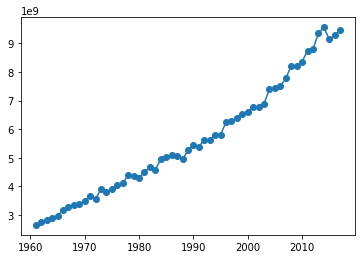

In [132]:
prod_per_year = prod_per_year_per_country.groupby('year').sum().reset_index()
plt.plot_date(x=prod_per_year['year'], y=prod_per_year['value'], linestyle="-", xdate=True)

Now, let us plot the trend for one of the countries that has been affected by war the most, Afghanistan:

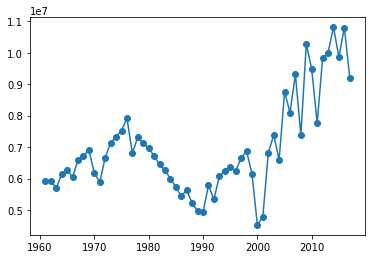

In [133]:
afghanistan_production = (
    prod_per_year_per_country[prod_per_year_per_country['country'] == 'Afghanistan']
        .drop('country', axis=1)
)

_ = plt.plot_date(x=afghanistan_production['year'], y=afghanistan_production['value'], linestyle="-", xdate=True)

In [134]:
fao_path = ''

crops_production_file = 'crops_production.csv'
livestock_production_file = 'livestock_production.csv'
trading_file = 'import_export.csv'
population_file = 'population.csv'
land_use_file = 'land_use.csv'

raw_crops_production_df = pd.read_csv(fao_path + crops_production_file, encoding='latin-1')
raw_livestock_production_df = pd.read_csv(fao_path + livestock_production_file, encoding='latin-1')
raw_trading_df = pd.read_csv(fao_path + trading_file, encoding='latin-1')
raw_population_df = pd.read_csv(fao_path + population_file, encoding='latin-1')
raw_land_use_df = pd.read_csv(fao_path + land_use_file, encoding='latin-1')

agricultural_dfs_names = ['crops', 'livestock', 'trading', 'population', 'land']

agricultural_dfs = [
    raw_crops_production_df,
    raw_livestock_production_df,
    raw_trading_df,
    raw_population_df,
    raw_land_use_df
]

for name, df in zip(agricultural_dfs_names, agricultural_dfs):
    print(f"Length of {name} dataframe: {df.size}")

Length of crops dataframe: 1437366
Length of livestock dataframe: 472752
Length of trading dataframe: 6933270
Length of population dataframe: 223725
Length of land dataframe: 170100


In [135]:
def drop_useless_columns(fao_df):

    fao_df = fao_df.drop(columns=[
        'Domain Code',
        'Area Code',
        'Domain',
        'Element Code',
        'Element',
        'Item Code',
        'Year Code',
        'Unit',
        'Flag',
        'Flag Description'
    ])
    
    try:
        fao_df = fao_df.drop('Note', axis=1)
    except KeyError:
        pass
    
    try:
        fao_df = fao_df.drop('Unnamed: 0', axis=1)
    except KeyError:
        pass

    fao_df = fao_df.rename(columns={
        'Area': 'country',
        'Item': 'item',
        'Year': 'year',
        'Value': 'value'
    })

    fao_df['year'] = pd.to_datetime(fao_df['year'], format='%Y')
    
    return fao_df

dropped_agricultural_dfs = list(map(drop_useless_columns, agricultural_dfs))

***Correlation production/used area***

In [136]:
land = dropped_agricultural_dfs[4]
land

,country,item,year,value
0,Afghanistan,Agricultural land,1961-01-01,37700.0
1,Afghanistan,Agricultural land,1962-01-01,37760.0
2,Afghanistan,Agricultural land,1963-01-01,37810.0
3,Afghanistan,Agricultural land,1964-01-01,37873.0
4,Afghanistan,Agricultural land,1965-01-01,37875.0
...,...,...,...,...
12145,Zimbabwe,Agricultural land,2013-01-01,16200.0
12146,Zimbabwe,Agricultural land,2014-01-01,16200.0
12147,Zimbabwe,Agricultural land,2015-01-01,16200.0
12148,Zimbabwe,Agricultural land,2016-01-01,16200.0


In [160]:
population = dropped_agricultural_dfs[3]
population = population.drop('item', axis = 1) ## Don't know its meaning
population

,country,year,value
0,Afghanistan,1950-01-01,7752.118
1,Afghanistan,1951-01-01,7840.156
2,Afghanistan,1952-01-01,7935.997
3,Afghanistan,1953-01-01,8039.694
4,Afghanistan,1954-01-01,8151.317
...,...,...,...
14910,Zimbabwe,2014-01-01,13586.707
14911,Zimbabwe,2015-01-01,13814.629
14912,Zimbabwe,2016-01-01,14030.331
14913,Zimbabwe,2017-01-01,14236.595


In [167]:
for country in population['country'].unique():
    print(country,":\n", population[population['country'] == country].value.describe())

Afghanistan :
 count       69.000000
mean     16610.597812
std       8488.736612
min       7752.118000
25%      10399.926000
50%      12882.528000
75%      21606.988000
max      37171.921000
Name: value, dtype: float64
Albania :
 count      69.000000
mean     2533.624246
std       644.632559
min      1263.174000
25%      1998.740000
50%      2882.740000
75%      3098.700000
max      3286.073000
Name: value, dtype: float64
Algeria :
 count       69.000000
mean     22791.334000
std      10180.761028
min       8872.247000
25%      13275.026000
50%      21763.575000
75%      31451.514000
max      42228.408000
Name: value, dtype: float64
American Samoa :
 count    69.000000
mean     39.528420
std      15.152424
min      18.940000
25%      25.248000
50%      37.946000
75%      55.713000
max      59.681000
Name: value, dtype: float64
Andorra :
 count    69.000000
mean     45.019333
std      26.335737
min       6.196000
25%      20.758000
50%      42.706000
75%      67.341000
max      84.46300

In [137]:
#land_afg = land[land['country'] == 'Afghanistan']
land_grouped = land.groupby('country').mean()
land_grouped # for each country, mean area used through the years

,value
country,
Afghanistan,37938.333333
Albania,1154.046860
Algeria,41575.879386
American Samoa,3.704035
Andorra,22.921228
...,...
Western Sahara,5002.859649
Yemen,23504.135088
Yugoslav SFR,14407.258065


In [138]:
land_afg['value'].describe()

count       57.000000
mean     37938.333333
std        107.271906
min      37700.000000
25%      37910.000000
50%      37911.000000
75%      38046.000000
max      38054.000000
Name: value, dtype: float64

We can see that the value is not changing a lot, we could reasonably divide by the mean

In [139]:
land_grouped = land.groupby('country').mean()
land_grouped #averaged used area through the years

,value
country,
Afghanistan,37938.333333
Albania,1154.046860
Algeria,41575.879386
American Samoa,3.704035
Andorra,22.921228
...,...
Western Sahara,5002.859649
Yemen,23504.135088
Yugoslav SFR,14407.258065


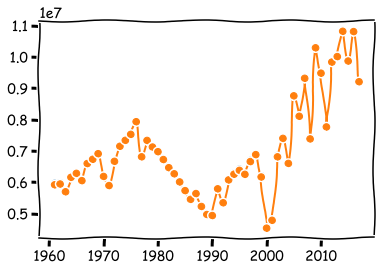

In [172]:
afg_production_raw = prod_per_year_per_country[prod_per_year_per_country['country'] == 'Afghanistan']['value']
afg_area = land_afg = land[land['country'] == 'Afghanistan']['value']

normalised_per_area = afg_production_raw/afg_area
plt.plot_date(x=afghanistan_production['year'], y=normalised_per_area*38000, linestyle="dotted", xdate=True)
## just a factor to have an easier comparison
## tadaaaa i the mean value
_ = plt.plot_date(x=afghanistan_production['year'], y=afghanistan_production['value'], linestyle="-", xdate=True)

## the plot we have is REALLY similar to the one we obtained before

In [141]:
print(len(prod_per_year_per_country))
prod_per_year_per_country['normalised_area'] = prod_per_year_per_country['value']/land['value']
prod_per_year_per_country

11397


,country,year,value,normalised_area
0,Afghanistan,1961-01-01,5909080.0,156.739523
1,Afghanistan,1962-01-01,5934534.0,157.164566
2,Afghanistan,1963-01-01,5686583.0,150.398916
3,Afghanistan,1964-01-01,6147934.0,162.330262
4,Afghanistan,1965-01-01,6274668.0,165.667802
...,...,...,...,...
11392,Zimbabwe,2013-01-01,3531221.0,121.766241
11393,Zimbabwe,2014-01-01,3637340.0,125.425517
11394,Zimbabwe,2015-01-01,2519574.0,86.881862
11395,Zimbabwe,2016-01-01,3054562.0,101.818733


In [ ]:
prod_per_year_per_country['normalised_pop'] = prod_per_year_per_country['value']/land['value']
prod_per_year_per_country

In [155]:
prod_per_year_per_country.corr() 

,value,normalised_area
value,1.000000,0.267923
normalised_area,0.267923,1.000000


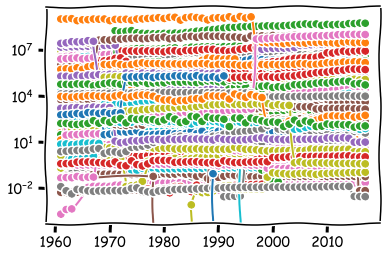

In [176]:
for country in prod_per_year_per_country['country'].unique():
    country_table = prod_per_year_per_country[prod_per_year_per_country['country'] == country]
    raw = country_table['value']
    area = country_table['normalised_area']
    #plt.plot_date(x=prod_per_year_per_country['year'].unique(), y=raw, linestyle="-", xdate=True)
    
    plt.plot_date(x=country_table['year'], y=area, linestyle="-", xdate=True, label=country)

plt.yscale("log")
#plt.plot_date(x=prod_per_year_per_country['year'], y=prod_per_year_per_country['value'], linestyle="dotted", xdate=True)
#plt.legend()

## Live Animal Population dataframe creation

In [57]:
fao_path = '../data/fao/'
animal_file = 'live_animal_population.csv'

raw_animal_population_df = pd.read_csv(fao_path + animal_file)
raw_animal_population_df.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QA,Live Animals,2,Afghanistan,5111,Stocks,1107,Asses,1961,1961,Head,1300000.0,NaN,Official data
1,QA,Live Animals,2,Afghanistan,5111,Stocks,1107,Asses,1962,1962,Head,851850.0,NaN,Official data
2,QA,Live Animals,2,Afghanistan,5111,Stocks,1107,Asses,1963,1963,Head,1001112.0,NaN,Official data
3,QA,Live Animals,2,Afghanistan,5111,Stocks,1107,Asses,1964,1964,Head,1150000.0,F,FAO estimate
4,QA,Live Animals,2,Afghanistan,5111,Stocks,1107,Asses,1965,1965,Head,1300000.0,NaN,Official data


Let us see the different elements in some features, in order to decide if we can drop them:

In [58]:
raw_animal_population_df.groupby('Flag Description').count()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag
Flag Description,,,,,,,,,,,,,
"Aggregate, may include official, semi-official, estimated or calculated data",968,968,968,968,968,968,968,968,968,968,968,968,968
Data not available,2723,2723,2723,2723,2723,2723,2723,2723,2723,2723,2723,0,2723
FAO data based on imputation methodology,3709,3709,3709,3709,3709,3709,3709,3709,3709,3709,3709,3709,3709
FAO estimate,39532,39532,39532,39532,39532,39532,39532,39532,39532,39532,39532,39532,39532
Official data,52131,52131,52131,52131,52131,52131,52131,52131,52131,52131,52131,52131,0
Unofficial figure,4290,4290,4290,4290,4290,4290,4290,4290,4290,4290,4290,4290,4290


In [59]:
raw_animal_population_df.groupby('Flag').count()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag Description
Flag,,,,,,,,,,,,,
*,4290,4290,4290,4290,4290,4290,4290,4290,4290,4290,4290,4290,4290
A,968,968,968,968,968,968,968,968,968,968,968,968,968
F,39532,39532,39532,39532,39532,39532,39532,39532,39532,39532,39532,39532,39532
Im,3709,3709,3709,3709,3709,3709,3709,3709,3709,3709,3709,3709,3709
M,2723,2723,2723,2723,2723,2723,2723,2723,2723,2723,2723,0,2723


In [60]:
raw_animal_population_df.groupby('Unit').count()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Value,Flag,Flag Description
Unit,,,,,,,,,,,,,
1000 Head,27676,27676,27676,27676,27676,27676,27676,27676,27676,27676,26394,15941,27676
Head,69230,69230,69230,69230,69230,69230,69230,69230,69230,69230,68047,31271,69230
No,6447,6447,6447,6447,6447,6447,6447,6447,6447,6447,6189,4010,6447


We see that there are three different units used in the data. We will investigate the "1000 Head" and the "No" units to determine whether we should simply drop them or modify them.

In [61]:
raw_animal_population_df.loc[raw_animal_population_df['Unit'] == 'No'].groupby('Item').count()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Year Code,Year,Unit,Value,Flag,Flag Description
Item,,,,,,,,,,,,,
Beehives,6447,6447,6447,6447,6447,6447,6447,6447,6447,6447,6189,4010,6447


We see that the only Item with "No" as a unit are Beehives. Here "No" stands for Number, and hence is equivalent to a head count ("Head"). We therefore have decided to leave these data points included as we will consider beehives as individuals in a beehive population.

In [62]:
raw_animal_population_df.loc[raw_animal_population_df['Unit'] == '1000 Head'].groupby('Item').count()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Year Code,Year,Unit,Value,Flag,Flag Description
Item,,,,,,,,,,,,,
Chickens,11326,11326,11326,11326,11326,11326,11326,11326,11326,11326,11223,6133,11326
Ducks,5192,5192,5192,5192,5192,5192,5192,5192,5192,5192,4877,3089,5192
Geese and guinea fowls,2892,2892,2892,2892,2892,2892,2892,2892,2892,2892,2761,1518,2892
"Pigeons, other birds",574,574,574,574,574,574,574,574,574,574,545,370,574
Rabbits and hares,3359,3359,3359,3359,3359,3359,3359,3359,3359,3359,2944,2251,3359
"Rodents, other",114,114,114,114,114,114,114,114,114,114,114,97,114
Turkeys,4219,4219,4219,4219,4219,4219,4219,4219,4219,4219,3930,2483,4219


The unit "1000 Head" is the same as "Head" but multiplied by 1000. We can simply multiply the values if these entries by 1000 and change 1000 Head to Head.

In [63]:
# Multiply each value with unit "1000 Head" by 1000
raw_animal_population_df.loc[raw_animal_population_df['Unit'] == '1000 Head'].Value.apply(lambda x: 1000*x)

# Replace "1000 Head" unit to "Head"
raw_animal_population_df.Unit.replace('1000 Head', 'Head', inplace=True);

In [64]:
animal_population_df = raw_animal_population_df.drop(columns=[
    'Domain Code',
    'Area Code',
    'Domain',
    'Element Code',
    'Element',
    'Item Code',
    'Year Code',
    'Unit',
    'Flag',
    'Flag Description'
])

animal_population_df = animal_population_df.rename(columns={
    'Area': 'country',
    'Item': 'item',
    'Year': 'year',
    'Value': 'value'
})

animal_population_df['year'] = pd.to_datetime(animal_population_df['year'], format='%Y')

We will now see if there are any missing values.

In [65]:
animal_population_df[animal_population_df.isnull().any(axis=1)]

,country,item,year,value
741,Albania,Ducks,1961-01-01,NaN
742,Albania,Ducks,1962-01-01,NaN
743,Albania,Ducks,1963-01-01,NaN
744,Albania,Ducks,1964-01-01,NaN
745,Albania,Ducks,1965-01-01,NaN
...,...,...,...,...
102443,Zambia,Beehives,1963-01-01,NaN
102444,Zambia,Beehives,1964-01-01,NaN
102445,Zambia,Beehives,1965-01-01,NaN
102446,Zambia,Beehives,1966-01-01,NaN


As we did for the crops dataset, we will set the NaN values to 0 in order to complete our general analysis of the data and investigate further later.

In [66]:
animal_population_df.loc[animal_population_df['value'].isnull(), 'value'] = 0

We will now compute the total animal population regardless of species in order to observe any general trends. We can later look into specific species if we deem necessary.

In [67]:
animals_per_year_per_country = (
    animal_population_df.groupby(['country', 'year'])
        .sum()
        .reset_index()
)

animals_per_year_per_country.head()

,country,year,value
0,Afghanistan,1961-01-01,26951541.0
1,Afghanistan,1962-01-01,26840240.0
2,Afghanistan,1963-01-01,27241382.0
3,Afghanistan,1964-01-01,27646000.0
4,Afghanistan,1965-01-01,28152300.0


## Import/Export Dataframe

In [68]:
fao_path = '../data/fao/'
impexp_file = 'afghan_leb_import_export.csv'

raw_impexp_df = pd.read_csv(fao_path + impexp_file)
raw_impexp_df.head()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,TP,Crops and livestock products,2,Afghanistan,5610,Import Quantity,231,Almonds shelled,2014,2014,tonnes,167.0,R,Estimated data using trading partners database
1,TP,Crops and livestock products,2,Afghanistan,5610,Import Quantity,231,Almonds shelled,2015,2015,tonnes,181.0,R,Estimated data using trading partners database
2,TP,Crops and livestock products,2,Afghanistan,5610,Import Quantity,231,Almonds shelled,2016,2016,tonnes,845.0,R,Estimated data using trading partners database
3,TP,Crops and livestock products,2,Afghanistan,5610,Import Quantity,231,Almonds shelled,2017,2017,tonnes,102.0,R,Estimated data using trading partners database
4,TP,Crops and livestock products,2,Afghanistan,5910,Export Quantity,231,Almonds shelled,1961,1961,tonnes,0.0,NaN,Official data


Let us see the different elements in some features, in order to decide if we can drop them:

In [69]:
raw_impexp_df.groupby('Flag').count()

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag Description
Flag,,,,,,,,,,,,,
*,4269,4269,4269,4269,4269,4269,4269,4269,4269,4269,4269,4269,4269
A,174,174,174,174,174,174,174,174,174,174,174,174,174
F,2901,2901,2901,2901,2901,2901,2901,2901,2901,2901,2901,2901,2901
Im,19,19,19,19,19,19,19,19,19,19,19,19,19
M,10340,10340,10340,10340,10340,10340,10340,10340,10340,10340,10340,0,10340
R,1791,1791,1791,1791,1791,1791,1791,1791,1791,1791,1791,1791,1791


In [70]:
impexp_df = raw_impexp_df.drop(columns=[
    'Domain Code',
    'Area Code',
    'Domain',
    'Element Code',
    'Item Code',
    'Year Code',
    'Unit',
    'Flag',
    'Flag Description'
])

impexp_df = impexp_df.rename(columns={
    'Area': 'country',
    'Item': 'item',
    'Year': 'year',
    'Value': 'value'
})

impexp_df['year'] = pd.to_datetime(impexp_df['year'], format='%Y')

We will now see if there are any missing values.

In [71]:
impexp_df[impexp_df.isnull().any(axis=1)]

,country,Element,item,year,value
73,Afghanistan,Export Quantity,"Anise, badian, fennel, coriander",1961-01-01,NaN
74,Afghanistan,Export Quantity,"Anise, badian, fennel, coriander",1962-01-01,NaN
75,Afghanistan,Export Quantity,"Anise, badian, fennel, coriander",1963-01-01,NaN
76,Afghanistan,Export Quantity,"Anise, badian, fennel, coriander",1964-01-01,NaN
77,Afghanistan,Export Quantity,"Anise, badian, fennel, coriander",1965-01-01,NaN
...,...,...,...,...,...
43499,Lebanon,Export Quantity,"Yoghurt, concentrated or not",1995-01-01,NaN
43500,Lebanon,Export Quantity,"Yoghurt, concentrated or not",1996-01-01,NaN
43501,Lebanon,Export Quantity,"Yoghurt, concentrated or not",1997-01-01,NaN
43503,Lebanon,Export Quantity,"Yoghurt, concentrated or not",1999-01-01,NaN


In [72]:
impexp_df.loc[impexp_df['value'].isnull(), 'value'] = 0

In [77]:
imp_df = impexp_df.loc[impexp_df['Element'] == 'Import Quantity']
imp_df.head()

exp_df = impexp_df.loc[impexp_df['Element'] == 'Export Quantity']
exp_df.head()

,country,Element,item,year,value
4,Afghanistan,Export Quantity,Almonds shelled,1961-01-01,0.0
5,Afghanistan,Export Quantity,Almonds shelled,1962-01-01,0.0
6,Afghanistan,Export Quantity,Almonds shelled,1963-01-01,0.0
7,Afghanistan,Export Quantity,Almonds shelled,1964-01-01,0.0
8,Afghanistan,Export Quantity,Almonds shelled,1965-01-01,0.0


In [78]:
imports_per_year_per_country = (
    imp_df.groupby(['country', 'year'])
        .sum()
        .reset_index()
)

imports_per_year_per_country.head()

exports_per_year_per_country = (
    exp_df.groupby(['country', 'year'])
        .sum()
        .reset_index()
)

exports_per_year_per_country.head()


,country,year,value
0,Afghanistan,1961-01-01,71164.0
1,Afghanistan,1962-01-01,76186.0
2,Afghanistan,1963-01-01,89659.0
3,Afghanistan,1964-01-01,95460.0
4,Afghanistan,1965-01-01,100746.0


Now, let us plot the production, coloring in red the years during which a war happened.

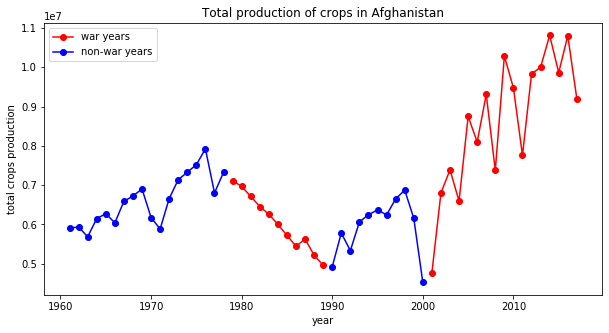

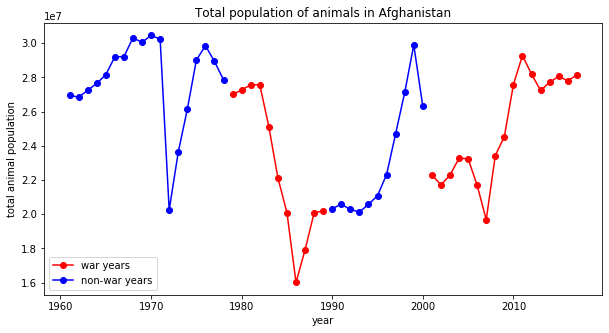

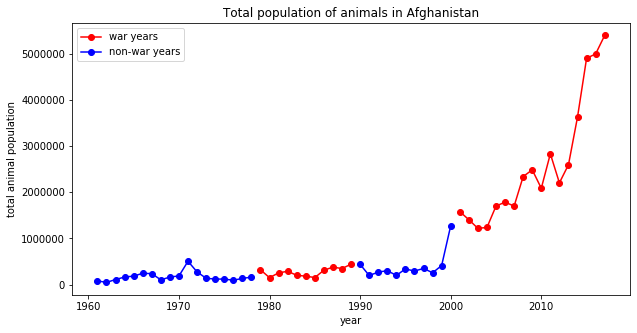

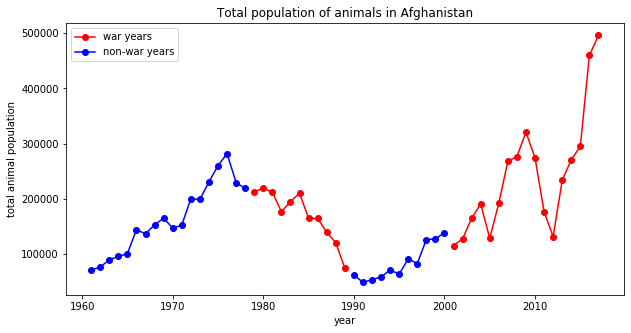

In [80]:
from src.plots import plot_animals_and_war, plot_production_and_war

country = "Afghanistan"

plot_production_and_war(final_wars_df, prod_per_year_per_country, country)

plot_animals_and_war(final_wars_df, animals_per_year_per_country, country)

plot_animals_and_war(final_wars_df, imports_per_year_per_country, country)

plot_animals_and_war(final_wars_df, exports_per_year_per_country, country)